# txx

## Modules Importeren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import optuna

2024-07-30 15:06:23.167976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Laden

In [2]:
atussum_2016 = pd.read_csv('atussum_2016.csv')
atussum_2017 = pd.read_csv('atussum_2017.csv')
atussum_2018 = pd.read_csv('atussum_2018.csv')
atussum_2019 = pd.read_csv('atussum_2019.csv')
atussum_2022 = pd.read_csv('atussum_2022.csv')

df_list = [atussum_2016, atussum_2017, atussum_2018, atussum_2019]

combined_df = pd.concat(df_list, ignore_index=True)

print(combined_df.head())

print(combined_df.shape)

         TUCASEID     TUFINLWGT  TRYHHCHILD  TEAGE  TESEX  PEEDUCA  PTDTRACE  \
0  20160101160045  2.458865e+07          -1     62      2       39         1   
1  20160101160066  5.445941e+06          -1     69      1       37         2   
2  20160101160069  8.782622e+06           0     24      2       39         2   
3  20160101160083  3.035910e+06           8     31      2       40         1   
4  20160101160084  6.978586e+06          -1     59      2       39         1   

   PEHSPNON  GTMETSTA  TELFS  ...  t119999  t130115  t130123  t130399  \
0         2         1      5  ...      NaN      NaN      NaN      NaN   
1         2         2      5  ...      NaN      NaN      NaN      NaN   
2         2         1      5  ...      NaN      NaN      NaN      NaN   
3         2         2      1  ...      NaN      NaN      NaN      NaN   
4         2         1      1  ...      NaN      NaN      NaN      NaN   

   t130402  t150899  t019999  t060402  t090302  t180599  
0      NaN      NaN   

## Data Preparation

In [3]:
asum1 = combined_df[(combined_df['TRERNWA'] != -1)]
asum1.loc[:, 'TRERNWA'] = asum1['TRERNWA'] / 100
df = asum1.fillna(0)


def sum_columns_with_prefix(df, prefix):
    cols_to_sum = [col for col in df.columns if col.startswith(prefix)]
    if cols_to_sum:
        return df[cols_to_sum].sum(axis=1)
    else:
        return pd.Series([0] * len(df), index=df.index)

prefixes = ['t01', 't02',  't03', 't04', 't05', 't06', 't07', 't08',  't09', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 't18']

sum_columns_dict = {}
for prefix in prefixes:
    sum_columns_dict[f'{prefix}_sum'] = sum_columns_with_prefix(df, prefix)

sum_df = pd.DataFrame(sum_columns_dict)
sum_df['TRERNWA'] = df['TRERNWA']
df= sum_df

print(df.shape)
df.head()

(21361, 18)


,t01_sum,t02_sum,t03_sum,t04_sum,t05_sum,t06_sum,t07_sum,t08_sum,t09_sum,t10_sum,t11_sum,t12_sum,t13_sum,t14_sum,t15_sum,t16_sum,t18_sum,TRERNWA
3,655.0,395.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.0,120.0,0.0,0,0.0,45,0.0,469.44
4,580.0,250.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,30.0,177.0,0.0,60,130.0,120,75.0,302.50
10,838.0,120.0,287.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,75.0,0.0,0,0.0,0,0.0,1538.46
11,555.0,20.0,40.0,0.0,480.0,0.0,0.0,0.0,15.0,0.0,75.0,65.0,0.0,0,0.0,0,190.0,1211.53
12,670.0,390.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,180.0,0.0,0,0.0,0,155.0,961.53


In [4]:
df2022 = atussum_2022[(atussum_2022['TRERNWA'] != -1)]
df2022.loc[:, 'TRERNWA'] = df2022['TRERNWA'] / 100
df2022 = df2022.fillna(0)


def sum_columns_with_prefix(df, prefix):
    cols_to_sum = [col for col in df.columns if col.startswith(prefix)]
    if cols_to_sum:
        return df[cols_to_sum].sum(axis=1)
    else:
        return pd.Series([0] * len(df), index=df.index)


sum_columns_dict = {}
for prefix in prefixes:
    sum_columns_dict[f'{prefix}_sum'] = sum_columns_with_prefix(df2022, prefix)

sum_df = pd.DataFrame(sum_columns_dict)
sum_df['TRERNWA'] = df2022['TRERNWA']
df2022= sum_df


print(df2022.shape)
df2022.head()

(4226, 18)


,t01_sum,t02_sum,t03_sum,t04_sum,t05_sum,t06_sum,t07_sum,t08_sum,t09_sum,t10_sum,t11_sum,t12_sum,t13_sum,t14_sum,t15_sum,t16_sum,t18_sum,TRERNWA
1,940,35,0,0,0,0,0,0,0,0,90,375,0,0,0,0,0,640.00
7,570,250,0,0,0,0,30,0,0,0,30,540,0,0,0,0,20,1750.00
8,1397,3,0,0,0,0,0,0,0,0,10,30,0,0,0,0,0,769.23
10,420,0,0,0,0,0,0,0,0,0,45,975,0,0,0,0,0,520.00
15,390,10,688,0,0,0,5,0,0,0,75,240,0,0,0,0,32,1615.38


In [5]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)

X_train = train_set.drop("TRERNWA", axis=1)
y_train = train_set["TRERNWA"]
X_test = test_set.drop("TRERNWA", axis=1)
y_test = test_set["TRERNWA"]

In [6]:
X_2022 = df2022.drop("TRERNWA", axis=1)
y_2022 = df2022["TRERNWA"]

## Modellen

### Klassieke Statistische Modellen

#### Lineaire Regressie


Test MAE: 568.6313170937984
R2 Score: 0.06582102946623236
______

2022 MAE: 627.5052724272351
2022 R2 Score: -0.042064036982228936



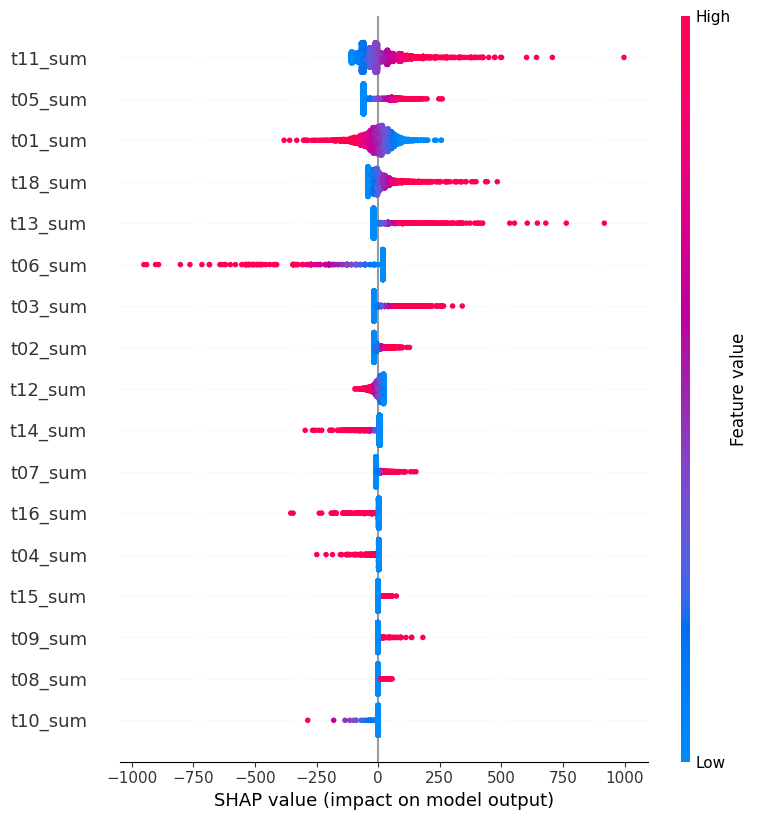

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Ridge Regressie

Beste hyperparameters: {'alpha': 0.1}

Test MAE: 568.6313384674858
R2 Score: 0.06582101376996452
______

2022 MAE: 627.5052305896074
2022 R2 Score: -0.04206396096794229



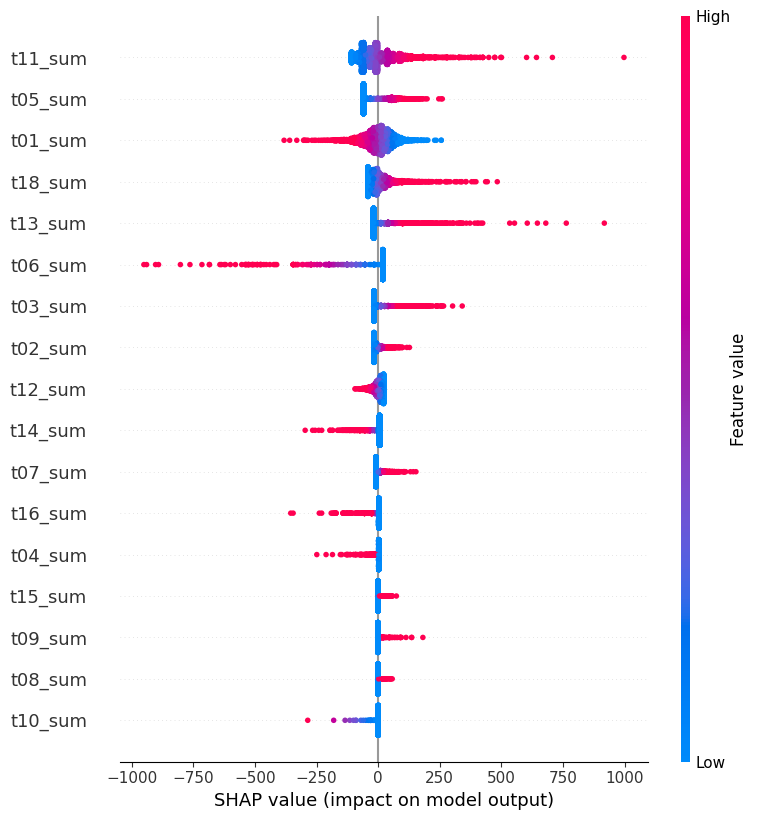

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

ridge_model = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_ridge_model = Ridge(alpha=best_params['alpha'])
best_ridge_model.fit(X_train_scaled, y_train)

y_pred = best_ridge_model.predict(X_test_scaled)
y_pred2022 = best_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Lasso Regressie

Beste hyperparameters: {'alpha': 0.1}

Test MAE: 568.6333257522911
R2 Score: 0.06582383956035154
______

2022 MAE: 627.493276079
2022 R2 Score: -0.042030415729499726



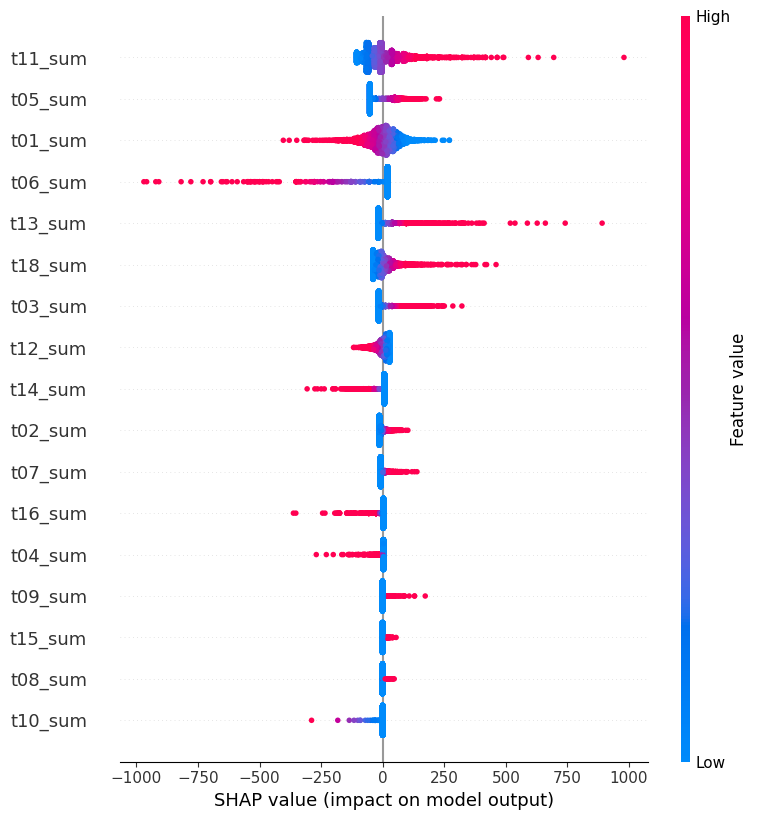

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

lasso_model = Lasso()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_lasso_model = Lasso(alpha=best_params['alpha'])
best_lasso_model.fit(X_train_scaled, y_train)

y_pred = best_lasso_model.predict(X_test_scaled)
y_pred2022 = best_lasso_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(best_lasso_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Bayesian Ridge Regression


Test MAE: 568.7376464569545
R2 Score: 0.06571935503616078
______

2022 MAE: 627.4849514492298
2022 R2 Score: -0.041982950174892064



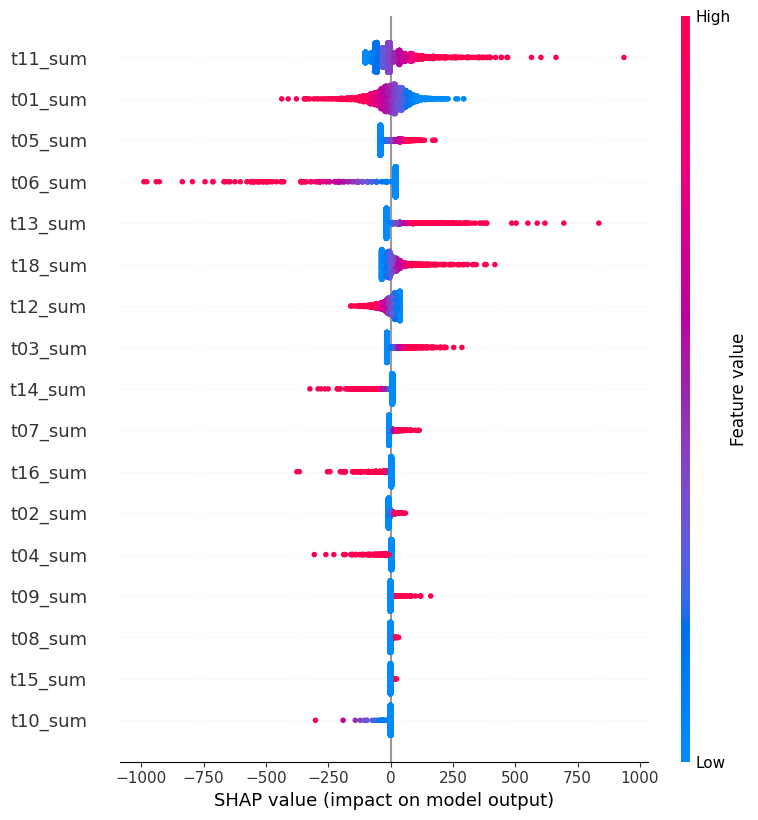

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train_scaled, y_train)

y_pred = bayesian_ridge_model.predict(X_test_scaled)
y_pred2022 = bayesian_ridge_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.LinearExplainer(bayesian_ridge_model, X_train_scaled)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

### Machine Learning Modellen

#### Decision Tree

Beste hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

Test MAE: 567.1681274999668
R2 Score: 0.06859700861243523
______

2022 MAE: 622.0264390071181
2022 R2 Score: -0.019787099533378427



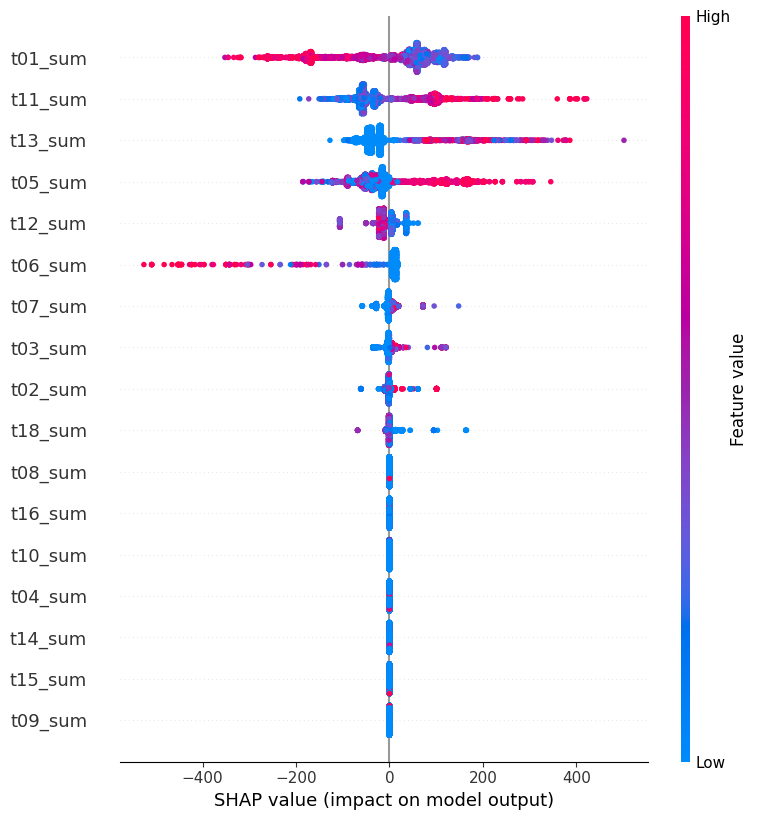

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_tree_model = DecisionTreeRegressor(**best_params)
best_tree_model.fit(X_train_scaled, y_train)

y_pred = best_tree_model.predict(X_test_scaled)
y_pred2022 = best_tree_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_tree_model)

shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)

plt.show()

#### Random Forests

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Test MAE: 551.8365641831282
R2 Score: 0.11937642804421067
______

2022 MAE: 609.2117794894701
2022 R2 Score: 0.011101659094116312



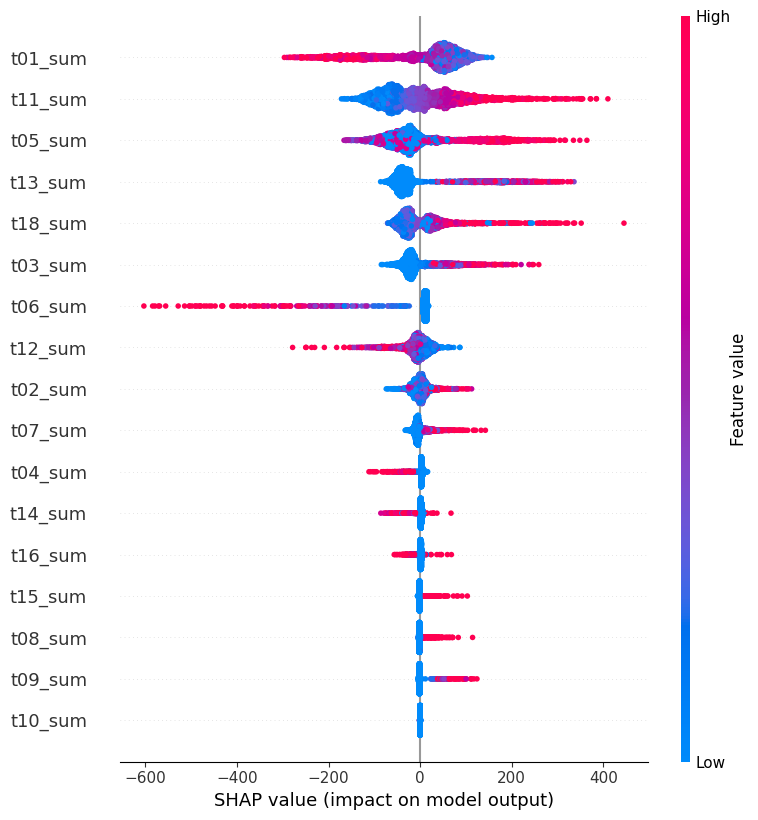

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

rf_model = RandomForestRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_rf_model = RandomForestRegressor(**best_params, random_state=10)
best_rf_model.fit(X_train_scaled, y_train)

y_pred = best_rf_model.predict(X_test_scaled)
y_pred2022 = best_rf_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_rf_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

#### Gradient Boosting Machines (GBM)

Beste hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Test MAE: 545.8768771133496
R2 Score: 0.13302674908624146
______

2022 MAE: 605.4157067199177
2022 R2 Score: 0.0261857640093206



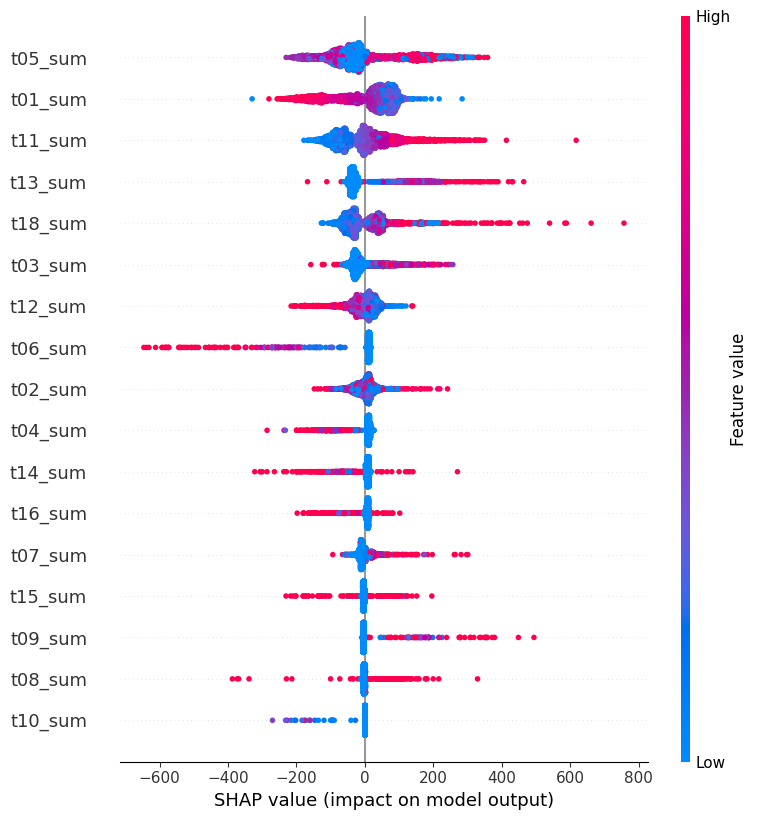

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

gbr_model = GradientBoostingRegressor(random_state=10)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=gbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_gbr_model = GradientBoostingRegressor(**best_params, random_state=10)
best_gbr_model.fit(X_train_scaled, y_train)

y_pred = best_gbr_model.predict(X_test_scaled)
y_pred2022 = best_gbr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

explainer = shap.TreeExplainer(best_gbr_model)
shap_values_test = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values_test, X_test_scaled, feature_names=X_train.columns)
plt.show()

#### Support Vector Machines (SVM)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

svr_model = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_scaled, y_train)

/Users/tristanglorie/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste hyperparameters: {'C': 100, 'epsilon': 1, 'kernel': 'rbf'}


SVR(C=100, epsilon=1)


Test MAE: 533.0011940276987
R2 Score: 0.05893339786291629
______

2022 MAE: 648.7404395683157
2022 R2 Score: -0.18879802480803098



  0%|          | 0/100 [00:00<?, ?it/s]

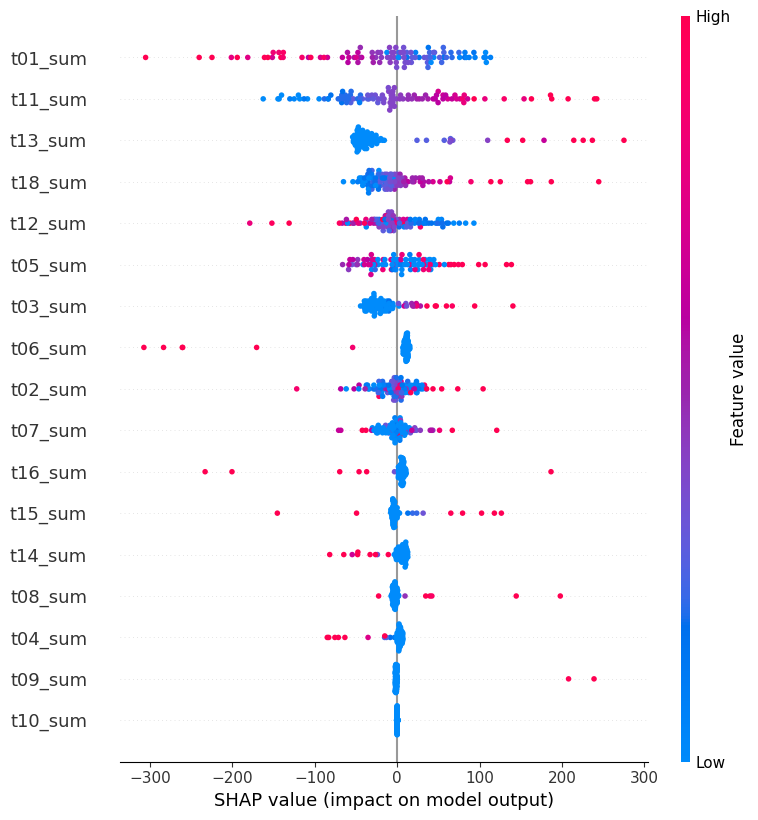

In [15]:
y_pred = best_svr_model.predict(X_test_scaled)
y_pred2022 = best_svr_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")

background = shap.kmeans(X_train_scaled, 50)  # Verminder aantal clusters
subset_size = 100
X_test_scaled_subset, y_test_subset = shuffle(X_test_scaled, y_test, random_state=1, n_samples=subset_size)

explainer = shap.KernelExplainer(best_svr_model.predict, background)
shap_values_test = explainer.shap_values(X_test_scaled_subset)

shap.summary_plot(shap_values_test, X_test_scaled_subset, feature_names=X_train.columns)
plt.show()

#### K-Nearest Neighbors (KNN)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Beste hyperparameters:", best_params)

best_knn_model = KNeighborsRegressor(**best_params)
best_knn_model.fit(X_train_scaled, y_train)

Beste hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'uniform'}


KNeighborsRegressor(algorithm='ball_tree', n_neighbors=11)

In [18]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

y_pred = best_knn_model.predict(X_test_scaled)
y_pred2022 = best_knn_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}\n")


Test MAE: 572.4842827053592
R2 Score: 0.04698729991643902
______

2022 MAE: 629.4708826313299
2022 R2 Score: -0.05460040068064287



### Deep Learning Modellen

2024-07-30 15:08:02.328863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
428/428 [==============================] - 1s 2ms/step - loss: 1343081.5000 - mae: 896.7239 - val_loss: 697901.8125 - val_mae: 592.3207
Epoch 2/100
428/428 [==============================] - 1s 1ms/step - loss: 575205.6875 - mae: 572.9059 - val_loss: 537033.2500 - val_mae: 559.8934
Epoch 3/100
428/428 [==============================] - 1s 1ms/step - loss: 545172.1875 - mae: 572.0875 - val_loss: 529164.5625 - val_mae: 562.9871
Epoch 4/100
428/428 [==============================] - 1s 2ms/step - loss: 538859.3750 - mae: 571.7690 - val_loss: 524466.3750 - val_mae: 559.4261
Epoch 5/100
428/428 [==============================] - 1s 1ms/step - loss: 534271.1250 - mae: 569.4186 - val_loss: 520183.5625 - val_mae: 561.0270
Epoch 6/100
428/428 [==============================] - 1s 1ms/step - loss: 530326.9375 - mae: 569.2996 - val_loss: 517666.4375 - val_mae: 555.3251
Epoch 7/100
428/428 [==============================] - 1s 2ms/step - loss: 527268.0625 - mae: 567.3770 - val_loss: 51

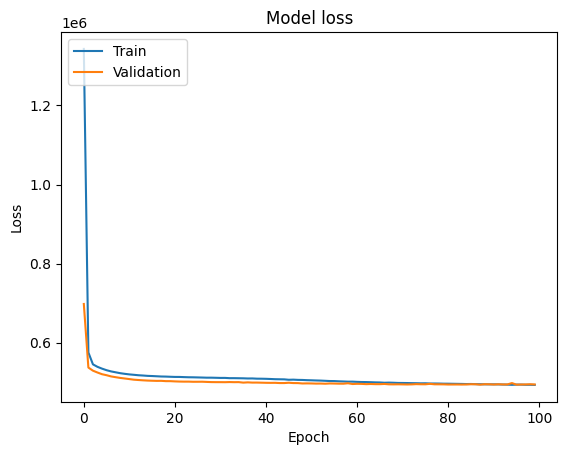

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"______\n\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

PermutationExplainer explainer: 4274it [03:19, 20.17it/s]                       


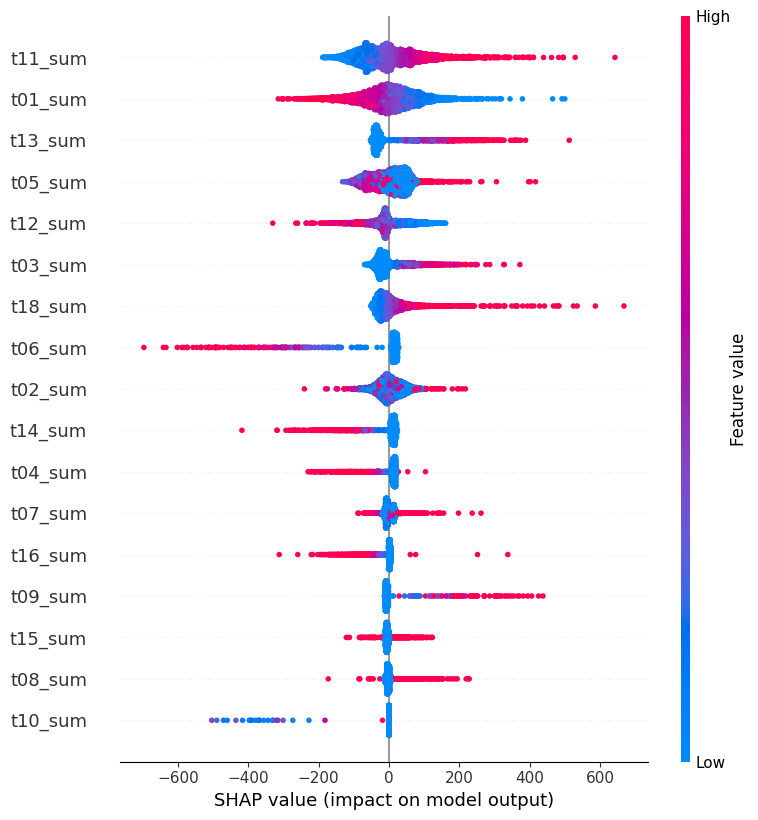

In [11]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Random Search

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

class IncomePredictionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

tuner = RandomSearch(
    IncomePredictionHyperModel(),
    objective='val_mae',
    max_trials=10,  
    executions_per_trial=2,  
    directory='my_dir',
    project_name='income_prediction5')

tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[EarlyStopping(patience=10)])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Trial 10 Complete [00h 01m 14s]
val_mae: 533.6880798339844

Best val_mae So Far: 530.2146911621094
Total elapsed time: 00h 10m 35s
Epoch 1/50
214/214 [==============================] - 2s 6ms/step - loss: 727313.8125 - mae: 645.8641 - val_loss: 542249.4375 - val_mae: 556.5014
Epoch 2/50
214/214 [==============================] - 1s 5ms/step - loss: 542051.5625 - mae: 572.6935 - val_loss: 518328.0312 - val_mae: 553.0117
Epoch 3/50
214/214 [==============================] - 1s 6ms/step - loss: 528696.5625 - mae: 568.2164 - val_loss: 511149.3438 - val_mae: 557.1209
Epoch 4/50
214/214 [==============================] - 1s 5ms/step - loss: 522375.0312 - mae: 567.0080 - val_loss: 509694.2500 - val_mae: 544.1006
Epoch 5/50
214/214 [==============================] - 1s 6ms/step - loss: 515949.9688 - mae: 563.5322 - val_loss: 508653.6250 - val_mae: 538.8685
Epoch 6/50
214/214 [==============================] - 1s 5ms/step - loss: 508865.5312 - mae: 559.6212 - val_loss: 505748.4062 - val_mae: 53

PermutationExplainer explainer: 4274it [23:19,  3.02it/s]                       


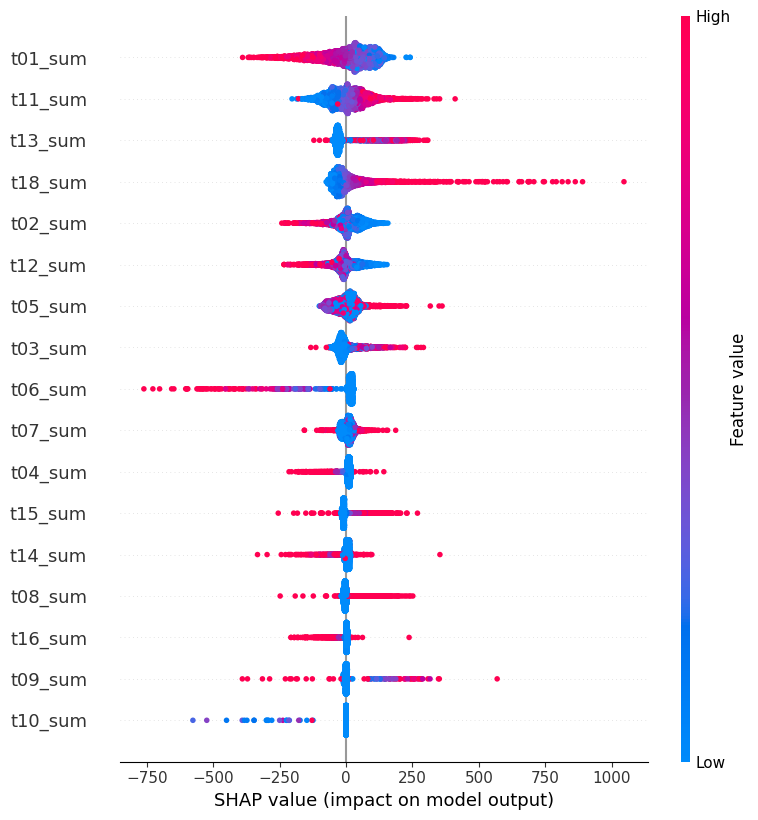

In [13]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)

#### Hyperparameter Tuning: Optuna

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

def create_model(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 16, 128, step=16)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_shape=(X_train_scaled.shape[1],)))

    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation=activation))

    model.add(Dense(1))

    optimizer = optimizer_name
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)


y_pred = best_model.predict(X_test_scaled)
y_pred2022 = best_model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

[I 2024-07-30 15:46:57,780] A new study created in memory with name: no-name-ac7419a8-0afe-48b2-86b2-213b37a178c9


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:47:18,054] Trial 0 finished with value: 1039.0636328287962 and parameters: {'num_layers': 1, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 1.787461527242803e-05}. Best is trial 0 with value: 1039.0636328287962.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:47:49,992] Trial 1 finished with value: 564.1588370875834 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0002585831867411602}. Best is trial 1 with value: 564.1588370875834.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:48:17,386] Trial 2 finished with value: 562.7109122407585 and parameters: {'num_layers': 1, 'num_units': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.002390239876139428}. Best is trial 2 with value: 562.7109122407585.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:48:44,811] Trial 3 finished with value: 565.2930715493154 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0017634222963451036}. Best is trial 2 with value: 562.7109122407585.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:49:13,211] Trial 4 finished with value: 1011.2747014774554 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 3.0238029545062724e-05}. Best is trial 2 with value: 562.7109122407585.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:49:40,742] Trial 5 finished with value: 564.4293801206397 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 3.576937769712355e-05}. Best is trial 2 with value: 562.7109122407585.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:50:07,316] Trial 6 finished with value: 605.1429141768856 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0018465838711238846}. Best is trial 2 with value: 562.7109122407585.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:50:35,794] Trial 7 finished with value: 1028.498714974705 and parameters: {'num_layers': 3, 'num_units': 16, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 6.427848667313483e-05}. Best is trial 2 with value: 562.7109122407585.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:51:01,925] Trial 8 finished with value: 951.228281158226 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00024606408062189875}. Best is trial 2 with value: 562.7109122407585.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:51:28,928] Trial 9 finished with value: 559.3162865828128 and parameters: {'num_layers': 3, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0018132539088645252}. Best is trial 9 with value: 559.3162865828128.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:51:41,548] Trial 10 finished with value: 560.9201680982194 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00841531577190375}. Best is trial 9 with value: 559.3162865828128.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:52:02,951] Trial 11 finished with value: 557.5163101229857 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.009980971605909135}. Best is trial 11 with value: 557.5163101229857.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:52:22,743] Trial 12 finished with value: 560.0551494562858 and parameters: {'num_layers': 3, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.008743448637814193}. Best is trial 11 with value: 557.5163101229857.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:52:49,258] Trial 13 finished with value: 560.6783120041197 and parameters: {'num_layers': 2, 'num_units': 48, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0007569202961574382}. Best is trial 11 with value: 557.5163101229857.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:53:11,156] Trial 14 finished with value: 555.5425932428069 and parameters: {'num_layers': 3, 'num_units': 16, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0050867719095808155}. Best is trial 14 with value: 555.5425932428069.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:53:38,207] Trial 15 finished with value: 556.2419505307558 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.004695896736166827}. Best is trial 14 with value: 555.5425932428069.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:53:58,511] Trial 16 finished with value: 558.7545732626993 and parameters: {'num_layers': 1, 'num_units': 16, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003388825283426533}. Best is trial 14 with value: 555.5425932428069.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:54:19,089] Trial 17 finished with value: 561.8574877212634 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0008990340259555172}. Best is trial 14 with value: 555.5425932428069.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:54:35,128] Trial 18 finished with value: 554.7740151102649 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004578759266383151}. Best is trial 18 with value: 554.7740151102649.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:54:57,618] Trial 19 finished with value: 559.7764890366976 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0005795614237050187}. Best is trial 18 with value: 554.7740151102649.


134/134 [==============================] - 0s 908us/step


[I 2024-07-30 15:55:16,570] Trial 20 finished with value: 866.3302027357955 and parameters: {'num_layers': 1, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 8.892656332937647e-05}. Best is trial 18 with value: 554.7740151102649.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:55:39,045] Trial 21 finished with value: 560.6421574737884 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004269244514716956}. Best is trial 18 with value: 554.7740151102649.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:55:54,978] Trial 22 finished with value: 558.0913063256075 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.004901444051397605}. Best is trial 18 with value: 554.7740151102649.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:56:13,852] Trial 23 finished with value: 560.2127159301843 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0048187030020756015}. Best is trial 18 with value: 554.7740151102649.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:56:36,539] Trial 24 finished with value: 552.7212092625686 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0011280310291895922}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:57:01,551] Trial 25 finished with value: 561.0824335181024 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0013042293209990364}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 15:57:22,263] Trial 26 finished with value: 654.5106773100786 and parameters: {'num_layers': 1, 'num_units': 96, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0004756797589321284}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:57:45,168] Trial 27 finished with value: 556.3023121059927 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001035765301718499}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:58:14,843] Trial 28 finished with value: 558.3791305555562 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.002773418681592393}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:58:40,213] Trial 29 finished with value: 656.0918194096746 and parameters: {'num_layers': 1, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00037948898124915293}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 15:59:10,975] Trial 30 finished with value: 582.7654282596802 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 1.1881427235417688e-05}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 15:59:38,718] Trial 31 finished with value: 561.6811595214158 and parameters: {'num_layers': 2, 'num_units': 16, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0064875253420698265}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:00:04,419] Trial 32 finished with value: 556.8451797408933 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0031170571722643693}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:00:31,695] Trial 33 finished with value: 566.5100096176436 and parameters: {'num_layers': 2, 'num_units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00018133090160223577}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 16:00:56,952] Trial 34 finished with value: 557.7486271397872 and parameters: {'num_layers': 1, 'num_units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.005712264087666542}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:01:27,391] Trial 35 finished with value: 563.5913094639259 and parameters: {'num_layers': 2, 'num_units': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.002665727942931366}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:01:57,348] Trial 36 finished with value: 558.3055445501504 and parameters: {'num_layers': 2, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0015786183404566093}. Best is trial 24 with value: 552.7212092625686.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 16:02:27,138] Trial 37 finished with value: 551.325116251761 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0021948305003902024}. Best is trial 37 with value: 551.325116251761.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:02:57,084] Trial 38 finished with value: 592.4011475192159 and parameters: {'num_layers': 2, 'num_units': 128, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0021178751433100418}. Best is trial 37 with value: 551.325116251761.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:03:17,641] Trial 39 finished with value: 556.1427385087642 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0013657460334004692}. Best is trial 37 with value: 551.325116251761.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:03:46,308] Trial 40 finished with value: 570.4670362700452 and parameters: {'num_layers': 2, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0006409778845692822}. Best is trial 37 with value: 551.325116251761.


134/134 [==============================] - 1s 2ms/step


[I 2024-07-30 16:04:05,475] Trial 41 finished with value: 558.2000211024804 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0013187794167295853}. Best is trial 37 with value: 551.325116251761.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 16:04:22,697] Trial 42 finished with value: 553.9170068716473 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0025204410196746543}. Best is trial 37 with value: 551.325116251761.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:04:43,854] Trial 43 finished with value: 545.3103953958266 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0038208546635197355}. Best is trial 43 with value: 545.3103953958266.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:05:01,014] Trial 44 finished with value: 555.6241634304084 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003473586285219127}. Best is trial 43 with value: 545.3103953958266.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:05:24,259] Trial 45 finished with value: 551.958455223621 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002534178235363245}. Best is trial 43 with value: 545.3103953958266.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:05:46,331] Trial 46 finished with value: 557.1664035554828 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0009827203293426106}. Best is trial 43 with value: 545.3103953958266.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:06:06,432] Trial 47 finished with value: 551.8971260824635 and parameters: {'num_layers': 3, 'num_units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0020159431201909866}. Best is trial 43 with value: 545.3103953958266.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:06:36,325] Trial 48 finished with value: 592.4432008704273 and parameters: {'num_layers': 3, 'num_units': 112, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0017312514053638766}. Best is trial 43 with value: 545.3103953958266.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 16:06:59,657] Trial 49 finished with value: 548.4358408541939 and parameters: {'num_layers': 3, 'num_units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002178627716431196}. Best is trial 43 with value: 545.3103953958266.


FrozenTrial(number=43, state=TrialState.COMPLETE, values=[545.3103953958266], datetime_start=datetime.datetime(2024, 7, 30, 16, 4, 22, 700024), datetime_complete=datetime.datetime(2024, 7, 30, 16, 4, 43, 854654), params={'num_layers': 3, 'num_units': 112, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0038208546635197355}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'num_units': IntDistribution(high=128, log=False, low=16, step=16), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None)}, trial_id=43, value=None)
133/133 [==============================] - 0s 2ms/step


Test MAE: 549.0818926616287
R2 Score: 0.10061148927242647

______
2022 MAE: 619.6045617241055
2022 R2 Score: -0.03606823928136138


PermutationExplainer explainer: 4274it [09:52,  7.08it/s]                       


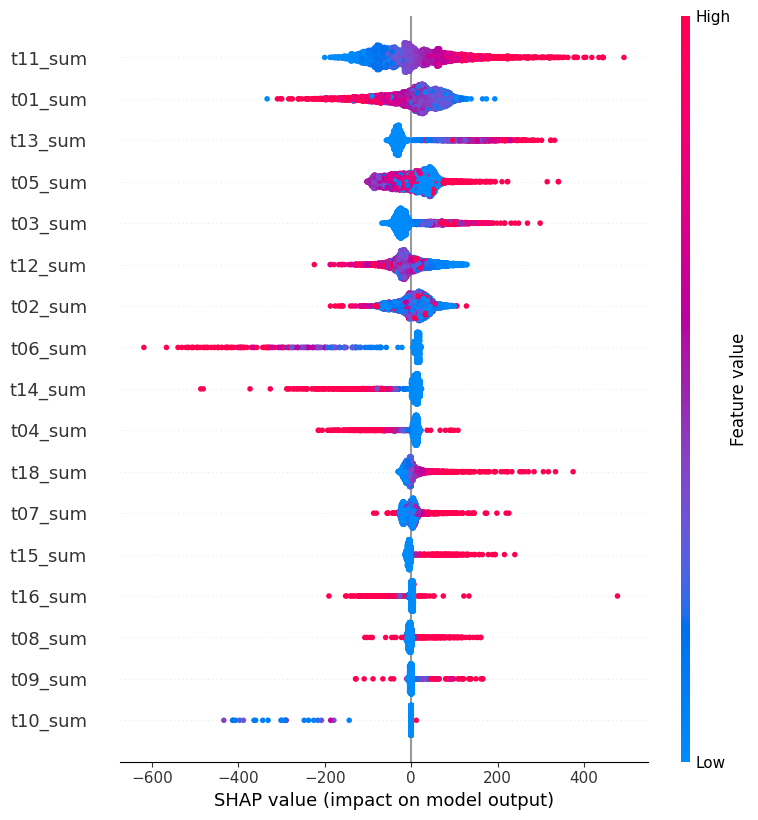

In [15]:
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

### 1D Convolutional Neural Network

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

y_pred = model.predict(X_test_scaled)
y_pred2022 = model.predict(X2022_scaled)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

Epoch 1/100
428/428 [==============================] - 2s 3ms/step - loss: 900918.6250 - mae: 718.9601 - val_loss: 561682.9375 - val_mae: 580.3578
Epoch 2/100
428/428 [==============================] - 1s 3ms/step - loss: 568618.2500 - mae: 593.6840 - val_loss: 545983.8750 - val_mae: 576.9092
Epoch 3/100
428/428 [==============================] - 1s 3ms/step - loss: 560619.3750 - mae: 592.0485 - val_loss: 538977.6875 - val_mae: 579.0244
Epoch 4/100
428/428 [==============================] - 1s 3ms/step - loss: 555978.9375 - mae: 590.6587 - val_loss: 535214.7500 - val_mae: 575.3752
Epoch 5/100
428/428 [==============================] - 1s 3ms/step - loss: 550934.3125 - mae: 587.4641 - val_loss: 531811.8125 - val_mae: 573.6315
Epoch 6/100
428/428 [==============================] - 1s 3ms/step - loss: 550463.1875 - mae: 587.9246 - val_loss: 529070.8750 - val_mae: 573.2812
Epoch 7/100
428/428 [==============================] - 1s 3ms/step - loss: 547464.8750 - mae: 586.0900 - val_loss: 527

#### Hyperparameter Tuning: Optuna

In [19]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X2022_scaled = scaler.transform(X_2022)

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_2022_cnn = X2022_scaled.reshape((X2022_scaled.shape[0], X2022_scaled.shape[1], 1))

def create_model(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    filters = trial.suggest_int('filters', 16, 128, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 128, step=16)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same', input_shape=(X_train_cnn.shape[1], 1)))

    for _ in range(num_conv_layers - 1):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def objective(trial):
    model = create_model(trial)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test_cnn)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(study.best_trial)

best_trial = study.best_trial
best_model = create_model(best_trial)
best_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)

[I 2024-07-30 17:51:41,371] A new study created in memory with name: no-name-f18bdd64-32c8-4e0a-98c0-9a814096409d


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 17:52:40,054] Trial 0 finished with value: 999.1579048849151 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.45011588514022255, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 5.487109867899788e-05}. Best is trial 0 with value: 999.1579048849151.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 17:54:09,323] Trial 1 finished with value: 1018.419597042806 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 4, 'activation': 'tanh', 'dropout_rate': 0.11581944964430563, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 1.8455525932647234e-05}. Best is trial 0 with value: 999.1579048849151.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 17:56:04,966] Trial 2 finished with value: 592.8347413549193 and parameters: {'num_conv_layers': 3, 'filters': 112, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.44286109756607406, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.004911631472814203}. Best is trial 2 with value: 592.8347413549193.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 17:58:19,525] Trial 3 finished with value: 563.6110387063021 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.21112979964385764, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0001513781704010101}. Best is trial 3 with value: 563.6110387063021.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 17:59:45,742] Trial 4 finished with value: 675.7459356082388 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.2794188162870059, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.001252001001708587}. Best is trial 3 with value: 563.6110387063021.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:00:30,470] Trial 5 finished with value: 596.6565511105798 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.374634104153696, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 3.194341505996743e-05}. Best is trial 3 with value: 563.6110387063021.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:01:32,564] Trial 6 finished with value: 545.0120071733235 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.05360686211800564, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.001062592843331363}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 1s 3ms/step


[I 2024-07-30 18:04:25,487] Trial 7 finished with value: 767.1164513483099 and parameters: {'num_conv_layers': 3, 'filters': 128, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.2740552083429334, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.000293657366845809}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:05:47,178] Trial 8 finished with value: 937.810356981102 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.48602051259702994, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 7.226696803245816e-05}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:06:56,461] Trial 9 finished with value: 1015.093875561872 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.09125846512129948, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 1.109325427544587e-05}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:07:57,493] Trial 10 finished with value: 555.8158330166114 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.048913178341936925, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0010835212254865334}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:08:43,579] Trial 11 finished with value: 552.9827493879629 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.022618673492604047, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0013738867620803157}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:09:38,119] Trial 12 finished with value: 557.9542666850948 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.001540446021463554, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0013966477847399239}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:10:20,455] Trial 13 finished with value: 548.2972392143323 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.16194181276993994, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.007551795263891485}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:10:51,935] Trial 14 finished with value: 550.7825397275589 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.17083538050446617, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.00892396339777517}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:11:29,829] Trial 15 finished with value: 553.9659649916744 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1516446421141711, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.004403426856296502}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:12:25,433] Trial 16 finished with value: 549.3644459511909 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.09046858728093013, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0005180933203574858}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:13:09,600] Trial 17 finished with value: 553.3431713424386 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.3266131291213171, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0031117214981575946}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:13:44,919] Trial 18 finished with value: 563.543065334671 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2015886152339728, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.00933226744258156}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:14:42,122] Trial 19 finished with value: 558.2324989665589 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.060072275217750604, 'dense_units': 80, 'optimizer': 'adam', 'learning_rate': 0.0005234904432570808}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:15:47,558] Trial 20 finished with value: 555.9471573559462 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.14510992290440144, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.003010526314519638}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 18:17:06,411] Trial 21 finished with value: 551.3950818596717 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.08923068759240685, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0005247721734957458}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:18:18,669] Trial 22 finished with value: 564.2351183819208 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.09674188758112379, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00018940987773370676}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:19:07,365] Trial 23 finished with value: 573.8285159795267 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.2342729612080203, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0005237225904894541}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:19:55,284] Trial 24 finished with value: 553.6809956085256 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.046032674471370896, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0007369461383478985}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:20:38,001] Trial 25 finished with value: 555.7281393419048 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.13001180830130238, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0027041611169199733}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:21:51,996] Trial 26 finished with value: 565.409765163344 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.18039106771582714, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0002557238218648507}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:22:46,035] Trial 27 finished with value: 582.0073857881246 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.07133263312946293, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.00011245392375999644}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:23:36,766] Trial 28 finished with value: 553.3240084512479 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.013042839398344608, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0020359985215982848}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:24:13,858] Trial 29 finished with value: 555.3885823657221 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.11533333983795781, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.005743753454599109}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:25:26,342] Trial 30 finished with value: 558.9936227746235 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.17078037533976384, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0008600169739903029}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:26:20,007] Trial 31 finished with value: 560.5520691083663 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.17522441794005986, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.009760874503074425}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 1s 5ms/step


[I 2024-07-30 18:27:41,766] Trial 32 finished with value: 550.847805386469 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.2340862021361635, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.005650042296710217}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 18:28:47,242] Trial 33 finished with value: 551.8465182030176 and parameters: {'num_conv_layers': 2, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.12171704247746158, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.007312139083257628}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 18:30:57,129] Trial 34 finished with value: 567.2588080132518 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.21239845014399483, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0022225631703969846}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 18:31:44,159] Trial 35 finished with value: 557.8221258147829 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.15486481285002635, 'dense_units': 96, 'optimizer': 'rmsprop', 'learning_rate': 0.004228862307932164}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 1s 4ms/step


[I 2024-07-30 18:33:38,528] Trial 36 finished with value: 592.6798999200557 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.2628923825463343, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0018809098768485359}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 18:34:36,370] Trial 37 finished with value: 549.9046496446335 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.03184662986052236, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.003699448563438746}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:35:39,400] Trial 38 finished with value: 564.5576236046725 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.030137260103392183, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.00041025948138417894}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:36:37,037] Trial 39 finished with value: 581.5807104469334 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.0919606775764757, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.000798913835019178}. Best is trial 6 with value: 545.0120071733235.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:37:17,746] Trial 40 finished with value: 536.0588239271189 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.06966623370742706, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.003962402893316179}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 976us/step


[I 2024-07-30 18:37:40,535] Trial 41 finished with value: 560.1493234924989 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.06882803276724599, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0036481539623158406}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:38:22,209] Trial 42 finished with value: 558.9917186200164 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.052139900475789994, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.0017245510036027428}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:38:53,660] Trial 43 finished with value: 560.1306842926618 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.03014358948119003, 'dense_units': 16, 'optimizer': 'rmsprop', 'learning_rate': 0.006577502304246588}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:39:38,231] Trial 44 finished with value: 586.4481995825898 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.0005755981822647416, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 2.8274220526588517e-05}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:40:18,403] Trial 45 finished with value: 590.0852547769973 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.108900285400434, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.0012910762974315012}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:41:41,384] Trial 46 finished with value: 556.091549902161 and parameters: {'num_conv_layers': 3, 'filters': 48, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.07446120319875771, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.004272025751756023}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:42:23,059] Trial 47 finished with value: 548.4530643457956 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.036692607462179096, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0009930184540302598}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:43:16,413] Trial 48 finished with value: 560.0507622115449 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.045262151990077354, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0009779296900208692}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:43:58,405] Trial 49 finished with value: 572.9871453218931 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.12988893241436283, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.00034975423137236086}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:44:59,340] Trial 50 finished with value: 571.5472925813132 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.3096054655050366, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0006414915423169754}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:45:40,799] Trial 51 finished with value: 545.6647335141943 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.027550715040674523, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.002690532331954057}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:46:18,962] Trial 52 finished with value: 554.3612746747439 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.08141674280737664, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0014880271936283124}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:46:46,368] Trial 53 finished with value: 553.5220204097963 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.01293383816047089, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.002889061090625933}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:47:30,383] Trial 54 finished with value: 552.3106511188474 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.05720381790478871, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0011598854947442608}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:48:07,478] Trial 55 finished with value: 550.430687797791 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.11062326393821478, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0021986943776079355}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:48:47,032] Trial 56 finished with value: 561.8681205746298 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.0442060708908474, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0002552028903014409}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:49:18,457] Trial 57 finished with value: 547.6997647546099 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.09397876502625192, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.007694228579200502}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:49:40,147] Trial 58 finished with value: 560.0446393187934 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.14079756347657862, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.007878022921261172}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:50:14,764] Trial 59 finished with value: 552.9896061916695 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.46896448152217957, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.005867086390506133}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:50:46,203] Trial 60 finished with value: 550.9539871072268 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.09932456125807192, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.004957192424083468}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:51:14,292] Trial 61 finished with value: 558.1172290275997 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.08032798332253292, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.002510797771409417}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:51:59,361] Trial 62 finished with value: 561.7986633720727 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.021057573520825643, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0006351224640219428}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:52:23,494] Trial 63 finished with value: 558.0569660395134 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.03837938522688313, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.008207913380798723}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:53:17,195] Trial 64 finished with value: 554.4250091882693 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.057264190208976815, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.001605931179832512}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 902us/step


[I 2024-07-30 18:54:06,885] Trial 65 finished with value: 562.1788582299873 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.06897354055245304, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00042066582944592755}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:54:50,808] Trial 66 finished with value: 559.4128536349529 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.0968158314594063, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.0033838514242168997}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:55:16,450] Trial 67 finished with value: 559.7145797684498 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.15310970610931746, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0072170724208266614}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:55:40,728] Trial 68 finished with value: 552.0737592305496 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.0002902280880590635, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.009939388728542158}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:56:29,952] Trial 69 finished with value: 564.4913859494186 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.4329377798150387, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0009701716314039274}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:57:15,207] Trial 70 finished with value: 564.9270990937257 and parameters: {'num_conv_layers': 1, 'filters': 48, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.19434854251762923, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.004524341885920743}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:57:39,739] Trial 71 finished with value: 557.3682938261276 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.021434837955494654, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0037071214311985763}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 18:58:06,989] Trial 72 finished with value: 552.5401411793301 and parameters: {'num_conv_layers': 1, 'filters': 96, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.060617591466872386, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.005424278340815949}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 18:58:40,850] Trial 73 finished with value: 551.0047575952989 and parameters: {'num_conv_layers': 1, 'filters': 80, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.041784760786233256, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.0027155906118178294}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 957us/step


[I 2024-07-30 18:59:18,233] Trial 74 finished with value: 550.1457126098032 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.03101989809690104, 'dense_units': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.003479178380600132}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:00:13,573] Trial 75 finished with value: 562.4679370023628 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.08479265953719836, 'dense_units': 112, 'optimizer': 'rmsprop', 'learning_rate': 0.0006943449496438562}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:00:50,695] Trial 76 finished with value: 549.4151856865716 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.10591891980354831, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.006218048277907037}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 19:01:45,774] Trial 77 finished with value: 549.8930754191128 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.1061684873582733, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0065307441291552045}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 19:02:49,638] Trial 78 finished with value: 558.7774659588664 and parameters: {'num_conv_layers': 1, 'filters': 112, 'kernel_size': 3, 'activation': 'relu', 'dropout_rate': 0.13567089495974932, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00012661518820344762}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 19:03:50,119] Trial 79 finished with value: 568.0393632086306 and parameters: {'num_conv_layers': 1, 'filters': 128, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.12147748596715896, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 6.010612885884579e-05}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 19:05:04,342] Trial 80 finished with value: 583.9131937730372 and parameters: {'num_conv_layers': 2, 'filters': 48, 'kernel_size': 3, 'activation': 'tanh', 'dropout_rate': 0.16519166605468286, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.0004664926180665907}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 19:06:01,178] Trial 81 finished with value: 555.5811078107973 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.10690643627322957, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.006276908354120992}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 19:07:03,464] Trial 82 finished with value: 554.4483611142091 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.06518238078373187, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.0067810410041878625}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 19:07:59,104] Trial 83 finished with value: 556.6164945745703 and parameters: {'num_conv_layers': 2, 'filters': 128, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.08764058928743265, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.00493396831391406}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 19:08:43,449] Trial 84 finished with value: 548.1336068663452 and parameters: {'num_conv_layers': 2, 'filters': 112, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.10352037255139404, 'dense_units': 112, 'optimizer': 'adam', 'learning_rate': 0.008694287478020203}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 3ms/step


[I 2024-07-30 19:09:55,273] Trial 85 finished with value: 552.342915338739 and parameters: {'num_conv_layers': 2, 'filters': 96, 'kernel_size': 5, 'activation': 'relu', 'dropout_rate': 0.12198554609110279, 'dense_units': 96, 'optimizer': 'adam', 'learning_rate': 0.008332044372612915}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 2ms/step


[I 2024-07-30 19:10:24,352] Trial 86 finished with value: 557.3720788277113 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 4, 'activation': 'relu', 'dropout_rate': 0.07418129503399039, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.00408689033354494}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:11:00,064] Trial 87 finished with value: 545.9101165921466 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.010004130589287352, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.009169513728723494}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:11:29,094] Trial 88 finished with value: 554.8525427083257 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.012310131105701913, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.00828458529361437}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:12:07,648] Trial 89 finished with value: 552.2574526942543 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.013423746174797017, 'dense_units': 48, 'optimizer': 'adam', 'learning_rate': 0.009654738972393596}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 865us/step


[I 2024-07-30 19:12:58,418] Trial 90 finished with value: 566.1334634218722 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.051462119031945606, 'dense_units': 16, 'optimizer': 'adam', 'learning_rate': 0.000322667084064548}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:13:42,018] Trial 91 finished with value: 545.3308128631543 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.036504822877065204, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.005165928772255638}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:14:18,005] Trial 92 finished with value: 547.320115304309 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.034576304981467326, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.005155189488990178}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:14:57,336] Trial 93 finished with value: 551.5199996249045 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.03670730949047972, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.005569906524333989}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:16:19,923] Trial 94 finished with value: 557.4275245687572 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.0237978835196775, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.004970544714262673}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:17:03,668] Trial 95 finished with value: 553.5506040103626 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.05003020036426331, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.002376312780953276}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:17:36,227] Trial 96 finished with value: 558.9451966511882 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.025143748288434187, 'dense_units': 32, 'optimizer': 'adam', 'learning_rate': 0.0031466932720968454}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:18:13,568] Trial 97 finished with value: 550.9195460872709 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.008374214548118653, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.007344044253145538}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:18:40,590] Trial 98 finished with value: 592.7747470959092 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 2, 'activation': 'tanh', 'dropout_rate': 0.06464380555585267, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0018099815974529862}. Best is trial 40 with value: 536.0588239271189.


134/134 [==============================] - 0s 1ms/step


[I 2024-07-30 19:19:22,480] Trial 99 finished with value: 550.1131656588701 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.039777136111625894, 'dense_units': 128, 'optimizer': 'adam', 'learning_rate': 0.004124135000834402}. Best is trial 40 with value: 536.0588239271189.


FrozenTrial(number=40, state=TrialState.COMPLETE, values=[536.0588239271189], datetime_start=datetime.datetime(2024, 7, 30, 18, 36, 37, 37953), datetime_complete=datetime.datetime(2024, 7, 30, 18, 37, 17, 746086), params={'num_conv_layers': 1, 'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'dropout_rate': 0.06966623370742706, 'dense_units': 80, 'optimizer': 'rmsprop', 'learning_rate': 0.003962402893316179}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_conv_layers': IntDistribution(high=3, log=False, low=1, step=1), 'filters': IntDistribution(high=128, log=False, low=16, step=16), 'kernel_size': IntDistribution(high=5, log=False, low=2, step=1), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dense_units': IntDistribution(high=128, log=False, low=16, step=16), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'learning_rate': FloatDistribu

In [20]:
y_pred = best_model.predict(X_test_cnn)
y_pred2022 = best_model.predict(X_2022_cnn)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae_2022 = mean_absolute_error(y_2022, y_pred2022)
r2_2022 = r2_score(y_2022, y_pred2022)

print(f"\n\nTest MAE: {mae}")
print(f"R2 Score: {r2}")
print(f"\n______\n2022 MAE: {mae_2022}")
print(f"2022 R2 Score: {r2_2022}")

133/133 [==============================] - 0s 1ms/step


Test MAE: 554.1639532949214
R2 Score: 0.10451270393827583

______
2022 MAE: 616.1866316052719
2022 R2 Score: -0.010246765243587364


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


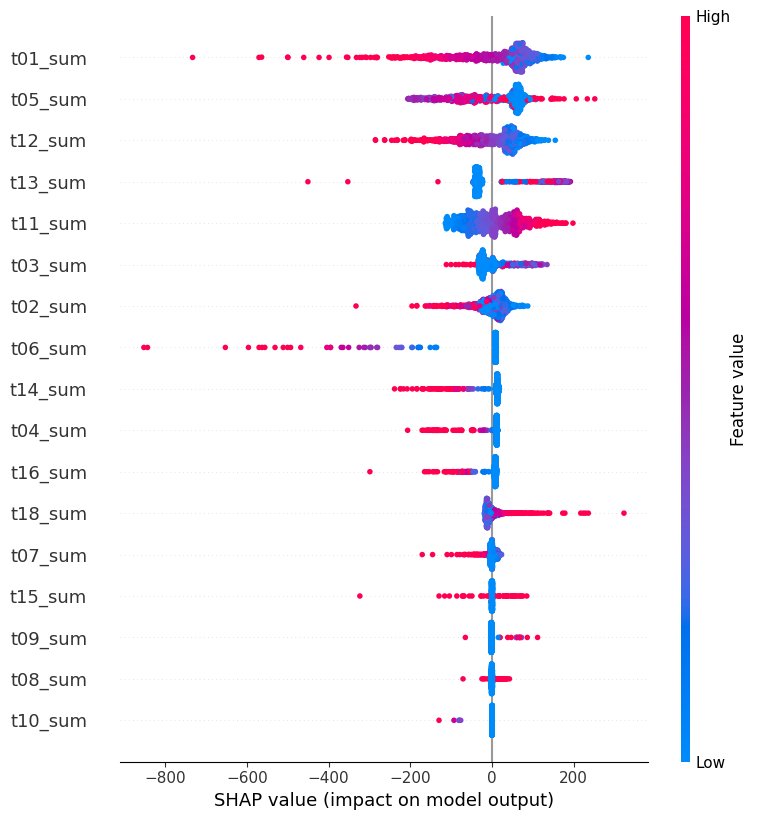

In [21]:
original_feature_names = X_train.columns.tolist()

background = X_train_cnn[np.random.choice(X_train_cnn.shape[0], 1000, replace=False)]

explainer = shap.DeepExplainer(best_model, background)

X_test_cnn_sample = X_test_cnn[np.random.choice(X_test_cnn.shape[0], 1000, replace=False)]
shap_values = explainer.shap_values(X_test_cnn_sample)

X_test_cnn_sample_2d = X_test_cnn_sample.reshape(X_test_cnn_sample.shape[0], -1)
shap_values_2d = np.array(shap_values).reshape(shap_values[0].shape[0], -1)

extended_feature_names = np.tile(original_feature_names, X_train_cnn.shape[1])

shap.summary_plot(shap_values_2d, X_test_cnn_sample_2d, feature_names=extended_feature_names)